In [ ]:
!pip install datasets -q
!pip install rouge_score
!pip install transformers
!pip install sentencepiece
!pip install rouge

In [ ]:
from datasets import load_metric
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartForConditionalGeneration, BartTokenizer
import torch
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Statistics of BBC News Dataset

In [ ]:
bbc_news = pd.read_csv('/content/drive/MyDrive/NLP Group Project/bbc_news_and_summary.csv')

In [ ]:
# Calculate the average sentences and tokens
def get_averages(target):
  sen_num = []
  tok_num = []

  for t in target:
    s_num = len(t.split('.')) - 1
    t_num = len(t.split(' '))

    sen_num.append(s_num)
    tok_num.append(t_num)
    
  return {'Average sentence':sum(sen_num)/len(sen_num),
          'Average tokens':sum(tok_num)/len(tok_num)}


In [ ]:
print(get_averages(bbc_news['Article']))

{'Average sentence': 19.63955056179775, 'Average tokens': 378.98426966292135}


In [ ]:
print(get_averages(bbc_news['Summary']))

{'Average sentence': 8.400898876404494, 'Average tokens': 165.21528089887641}


In [ ]:
# Detect and remove the outliers

def get_outlier_ind(all_summary_len):
  q1,q3 = np.percentile(sorted(all_summary_len), [25,75])
  iqr = q3 - q1
  lower_bound = q1 - (1.5 * iqr) 
  upper_bound = q3 + (1.5 * iqr) 

  outlier = []
  for i, length in enumerate(all_summary_len):
    if length > upper_bound:
      outlier.append(i)

  return outlier

sum_len = [len(i.split()) for i in bbc_news['Summary']]
outlier_ind = get_outlier_ind(sum_len)

nor_bbc_news = bbc_news.drop(outlier_ind, axis=0)
nor_bbc_news.shape

(2160, 5)

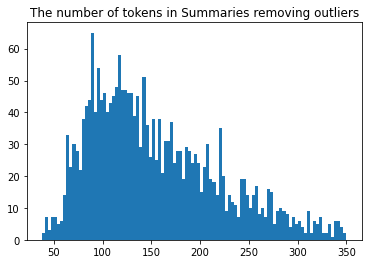

In [ ]:
new_sum_len = [len(i.split()) for i in nor_bbc_news['Summary']]

plt.hist(new_sum_len, bins=100)
plt.title('The number of tokens in Summaries removing outliers')
plt.show()

# Predicting 

In [ ]:
# Load T5 models
t5_model_name = 't5-small'
torch_device = 'cuda'
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(torch_device)
t5_model_path = '/content/drive/MyDrive/NLP Group Project/Models/checkpoints/t5_cnn_model/checkpoint-275000'
t5_trained_model = T5ForConditionalGeneration.from_pretrained(t5_model_path).to(torch_device)

bart_name = 'facebook/bart-base'
bart_tokenizer = BartTokenizer.from_pretrained(bart_name)
bart_model = BartForConditionalGeneration.from_pretrained(bart_name).to(torch_device)
bart_path = '/content/drive/MyDrive/NLP Group Project/Models/checkpoints/bart_cnn_model/checkpoint-56000'
bart_train_model = BartForConditionalGeneration.from_pretrained(bart_path).to(torch_device)


Some weights of the model checkpoint at t5-small were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 

In [ ]:
bbc_news = pd.read_csv('/content/drive/MyDrive/NLP Group Project/bbc_news_and_summary.csv')

In [ ]:
t5_train_summary_pred = []
for article in bbc_news.Article.to_list(): 
  batch = t5_tokenizer.prepare_seq2seq_batch(src_texts=[article], truncation=True, padding='longest', return_tensors='pt').to(torch_device)
  summarized = t5_trained_model.generate(**batch)
  summ_text = t5_tokenizer.batch_decode(summarized, skip_special_tokens=True)
  t5_train_summary_pred += summ_text

In [ ]:
t5_summary_pred = []
for article in bbc_news.Article.to_list(): 
  batch = t5_tokenizer.prepare_seq2seq_batch(src_texts=[article], truncation=True, padding='longest', return_tensors='pt').to(torch_device)
  summarized = t5_model.generate(**batch)
  summ_text = t5_tokenizer.batch_decode(summarized, skip_special_tokens=True)
  t5_summary_pred += summ_text

In [87]:
for i, summ in enumerate(t5_summary_pred[:20]):
  print(i, summ)

0 to tackle US visa regulations, which are blamed for hindering British acts' chances of
1 the band have done "everything in their considerable powers" to ensure they remain the
2 Pete Doherty has been involved in a fight with his band's guitarist
3 and, Jim Carrey, took $30.2m (£15.5m)
4 , Ocean's Twelve, took $40.8m (£21m) in weekend ticket
5 the 'art of screen acting' has two chapters - 'Before
6 Pete Doherty, 25, was arrested following an alleged incident in a hotel
7 the number one spot at the North American box office for a second week. it
8 Scissor Sisters have won gig of the year award for their performance at this
9 Depp, whose latest role was JM Barrie in Finding Neverland,
10 will play the part of a spider in a new film version of children's
11 the number of British films produced in the UK fell 40% in 2004. twenty-s
12 the the Morrissey, Patti Smith and Nick Cave have been artistic
13 , and Best British group,, three and Almost Here, the due
14 the the the the the the the t

In [ ]:
bart_summary_pred = []
for article in bbc_news.Article.to_list(): 
  batch = bart_tokenizer.prepare_seq2seq_batch(src_texts=[article], truncation=True, padding='longest', return_tensors='pt').to(torch_device)
  summarized = bart_model.generate(**batch)
  summ_text = bart_tokenizer.batch_decode(summarized, skip_special_tokens=True)
  bart_summary_pred += summ_text

In [ ]:
for i, summ in enumerate(bart_summary_pred[:20]):
  print(i, summ)

0 Musicians' groups are to tackle US visa regulations which are blamed for hindering British
1 U2, who have won three prestigious Grammy Awards for their hit Vertigo, are
2 Rock singer Pete Doherty has been involved in a fight with his band's guitarist at
3 The film adaptation of Lemony Snicket novels has topped the North America box office chart
4 Ocean's Twelve, the crime caper sequel starring George Clooney, Brad Pitt and
5 US film professionals have declared Fahrenheit 9/11 and The Passion of the Christ as two
6 Singer Pete Doherty will have to spend the weekend in jail because he could not
7 Comedy Meet The Fockers has held on to the number one spot at the
8 New York band Scissor Sisters have won a gig of the year award for their
9 Johnny Depp, whose latest role was Peter Pan creator JM Barrie in Finding Never
10 Actress Julia Roberts will play the part of a spider in a new film version of
11 The number of British films produced in the UK fell 40% in 2004, with movies
12 Rock star

In [ ]:
bart_train_summary_pred = []
for article in bbc_news.Article.to_list():
  batch = bart_tokenizer.prepare_seq2seq_batch(src_texts=[article], truncation=True, padding='longest', return_tensors='pt').to(torch_device)
  summarized = bart_train_model.generate(**batch)
  summ_text = bart_tokenizer.batch_decode(summarized, skip_special_tokens=True)
  bart_train_summary_pred += summ_text

In [ ]:
for i, summary in enumerate(bbc_news.Summary.to_list()[:20]):
  print(i, summary)

0 Nigel McCune from the Musicians' Union said British musicians are "disadvantaged" compared to their US counterparts.A US Embassy spokesman said: "We are aware that entertainers require visas for time-specific visas and are doing everything we can to process those applications speedily."The Musicians' Union stance is being endorsed by the Music Managers' Forum (MMF), who say British artists face "an uphill struggle" to succeed in the US, thanks to the tough visa requirements, which are also seen as impractical.Musicians' groups are to tackle US visa regulations which are blamed for hindering British acts' chances of succeeding across the Atlantic."The US is the world's biggest music market, which means something has to be done about the creaky bureaucracy," says Mr McCune."The current situation is preventing British acts from maintaining momentum and developing in the US," he added.A singer hoping to perform in the US can expect to pay $1,300 (£680) simply for obtaining a visa.
1 But 

In [ ]:
def remove_repeats(summaries, threshold = 2):
  summ_freq = Counter(summaries)
  repeats = {key: value for key, value in summ_freq.items() if value > threshold}
  repeat_sums = set(repeats.keys())
  non_rep_summaries = [i if i not in repeat_sums else "" for i in summaries]
  return non_rep_summaries

non_bart_train_sums = remove_repeats(bart_train_summary_pred)
for i, summ in enumerate(non_bart_train_sums[:20]):
  print(i, summ)

0 Singer hoping to perform in the US can expect to pay $1,300 (£
1 NEW: U2's new album, How To Dismantle An Atomic Bomb, is
2 Pete Doherty and his bandmates played for 5,000 fans at London's
3 The film adaptation of Lemony Snicket novels has topped the North America box office chart
4 
5 
6 Singer Pete Doherty was granted bail with curfew restrictions at Highbury Corner Magistrates
7 
8 
9 
10 Serena Williams will play the part of a spider in a new film version of
11 NEW: "We are in a hiatus," UK Film Council says.
UK and
12 Patti Smith has been made artistic director of this year's Meltdown festival.

13 
14 
15 Snoop Dogg has been sued for $25m (£13m) by
16 
17 
18 Mira Nair said she jumped at the chance to work on Vanity Fair.

19 The film was never shown in any cinema in Austria and was not broadcast on television until


In [ ]:
non_t5_train_sums = remove_repeats(t5_train_summary_pred, 2)
for i, summ in enumerate(non_t5_train_sums[:20]):
  print(i, summ)

0 The 'raw deal' faced by British musicians is not faced with comparable expense and bureaucra
1 
2 
3 
4 
5 
6 
7 
8 The 'Scitizen Sisters' are a disco-rock band
9 
10 
11 
12 
13 
14 
15 
16 
17 The 'Sea of the Dead' award-winning abortion drama Vera Drake has
18 The 'Sea' is a'seen' and '
19 The Sound of Music is to be staged in Vienna on Saturday. Julie Andrews


# Evaluations

In [ ]:
def get_eval(reference, prediction):
  ''' 
  Args:
    predictions: list of predictions to score. Each predictions should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each reference should be a string with tokens separated by spaces.
    
  Returns:
    rouge1: rouge_1 (f1),
    rouge2: rouge_2 (f1),
    rougeL: rouge_l (f1)
    bleu_smooth: smoothed bleu
  '''

  rouge = load_metric('rouge')
  bleu = load_metric('bleu')

  rouge_score = rouge._compute(prediction,reference)
  # return high rouge-1 fmeasure
  rouge1 = rouge_score['rouge1'][-1][-1]
  rouge1_prec = rouge_score['rouge1'][-1][0]
  rouge2 = rouge_score['rouge2'][-1][-1]
  rouge2_prec = rouge_score['rouge2'][-1][0]
  rougeL = rouge_score['rougeL'][-1][-1]
  rougeL_prec = rouge_score['rougeL'][-1][0]
  pred_tok = [ins.split() for ins in prediction]
  ref_tok = [[ins.split()] for ins in reference]
  
  bleu_score = bleu._compute(pred_tok,ref_tok)
  bleu_ = bleu_score['bleu']
  bp = bleu_score['brevity_penalty']

  return {'rouge1':rouge1,'rouge2':rouge2,'rougeL':rougeL,
          'precision1': rouge1_prec, 'precision2':rouge2_prec,
          'precisionL': rougeL_prec,'bleu':bleu_,'brevity_penalty':bp}


## Baseline model Evaluation

In [ ]:
reference = nor_bbc_news['Summary'].tolist()
b3_predicts = nor_bbc_news['Lead-3'].tolist()
b1_predicts = nor_bbc_news['Lead-1'].tolist()

base_3_eval = get_eval(reference,prediction)
base_1_eval = get_eval(reference, b1_predicts)
tune_bart_eval = get_eval(reference, non_bart_train_sums)
base_bart_eval = get_eval(reference, bart_summary_pred)
tune_t5_eval = get_eval(reference, non_t5_train_sums)
base_t5_eval = get_eval(reference, t5_summary_pred)



In [ ]:
tuned_bart_matching = [(i,j) for i, j in zip(non_bart_train_sums, reference) if len(i)>0]
tuned_t5_matching = [(i,j) for i, j in zip(non_t5_train_sums, reference) if len(i)>0]
tune_t5, t5_ref = list(zip(*tuned_bart_matching))
tune_bart, bart_ref = list(zip(*tuned_t5_matching))

match_t5_eval = get_eval(t5_ref, tune_t5)
match_bart_eval = get_eval(bart_ref, tune_bart)

In [86]:
match_t5_eval

{'bleu': 1.3721773610347786e-07,
 'brevity_penalty': 1.7634890444474304e-05,
 'precision1': 0.2924548852111357,
 'precision2': 0.022969010440059494,
 'precisionL': 0.24181405811209344,
 'rouge1': 0.0498146693778527,
 'rouge2': 0.003452743075934218,
 'rougeL': 0.040568550005642724}